In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon, SNN

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
mnist = MNIST("./data", train=True, download=False)

In [3]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:14<00:00, 4032.54item/s]


In [4]:
train_loader = DataLoader(train, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [56]:
params = {
    "lr": 5e-4,
    "optimizer": "Adam",
    "batch_size": 512,
    "beta": 1 / 8,
    "gamma": 100,
    "z_channels": 8,
    "contrastive_module": "SNN",
    "temperature": 0.1,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=params["z_channels"],
    norm_channels=32,
    n_heads=4,
).cuda()

trainer = CLEAR_VAEFirstStageTrainer(
    contrastive_criterion=eval(params["contrastive_module"])(temperature=params["temperature"]),
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="cuda",
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["lr"],
    },
)

In [57]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=51, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 79/79 [00:01<00:00, 71.20batch/s]


epoch 0/val_rec: 63.4750
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.21batch/s]


epoch 2/val_rec: 29.9604
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.65batch/s]


epoch 4/val_rec: 25.3868
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.01batch/s]


epoch 6/val_rec: 21.4511
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.44batch/s]


epoch 8/val_rec: 18.2551
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.14batch/s]


epoch 10/val_rec: 16.0796
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.04batch/s]


epoch 12/val_rec: 14.7337
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 67.13batch/s]


epoch 14/val_rec: 13.7078
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 66.95batch/s]


epoch 16/val_rec: 12.4385
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.39batch/s]


epoch 18/val_rec: 11.8848
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 66.05batch/s]


epoch 20/val_rec: 10.9695
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 64.99batch/s]


epoch 22/val_rec: 10.9878


100%|██████████| 79/79 [00:01<00:00, 68.46batch/s]


epoch 24/val_rec: 10.8747
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.14batch/s]


epoch 26/val_rec: 12.3706


100%|██████████| 79/79 [00:01<00:00, 67.83batch/s]


epoch 28/val_rec: 11.0710


100%|██████████| 79/79 [00:01<00:00, 68.59batch/s]


epoch 30/val_rec: 11.7081


100%|██████████| 79/79 [00:01<00:00, 68.09batch/s]


epoch 32/val_rec: 10.4631


100%|██████████| 79/79 [00:01<00:00, 68.17batch/s]


epoch 34/val_rec: 9.6509
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 67.71batch/s]


epoch 36/val_rec: 9.4924
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 66.60batch/s]


epoch 38/val_rec: 9.4383
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 65.41batch/s]


epoch 40/val_rec: 9.7045


100%|██████████| 79/79 [00:01<00:00, 67.78batch/s]


epoch 42/val_rec: 10.0517


100%|██████████| 79/79 [00:01<00:00, 67.39batch/s]


epoch 44/val_rec: 10.2455


100%|██████████| 79/79 [00:01<00:00, 67.43batch/s]


epoch 46/val_rec: 9.5542


100%|██████████| 79/79 [00:01<00:00, 68.56batch/s]


epoch 48/val_rec: 9.2031


100%|██████████| 79/79 [00:01<00:00, 68.57batch/s]


epoch 50/val_rec: 9.2401
[INFO]: log best model


In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

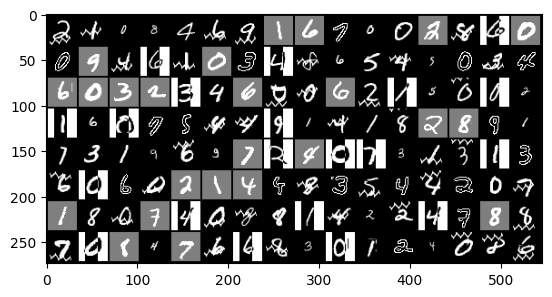

In [10]:
batch = next(iter(test_loader))
x, y = batch['image'].to("cuda"), batch['label'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

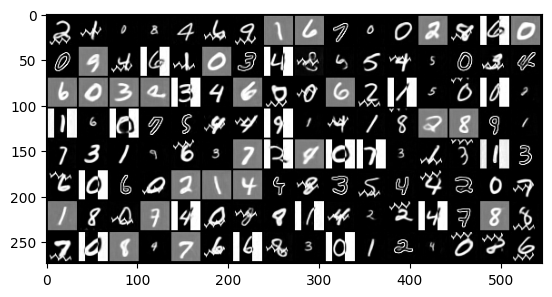

In [58]:
x = next(iter(test_loader))['image'].to("cuda")
best_model = mlflow.pytorch.load_model('runs:/96c3e27e9e5a411b898e4574f7944790/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

torch.Size([128, 8, 8, 8])


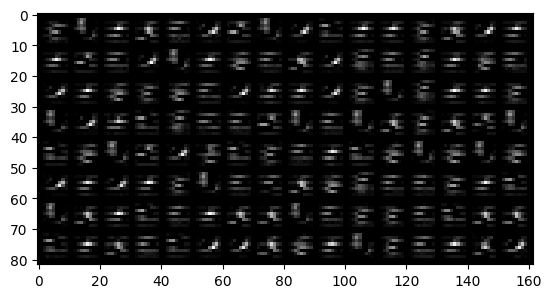

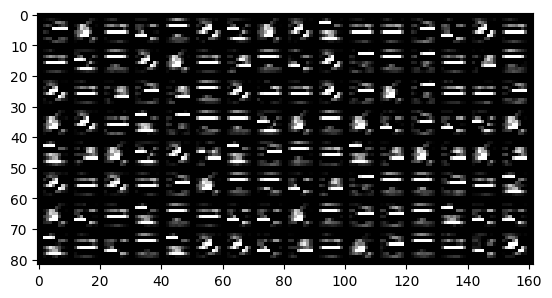

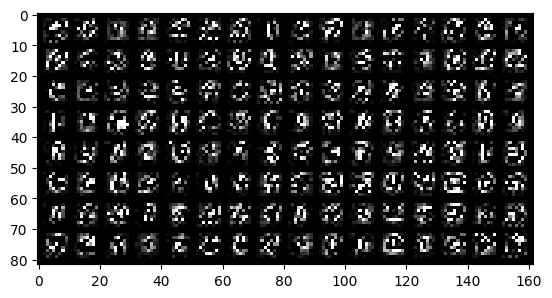

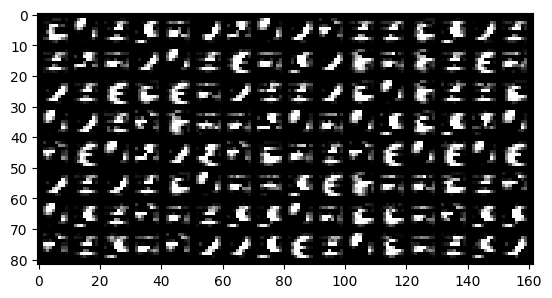

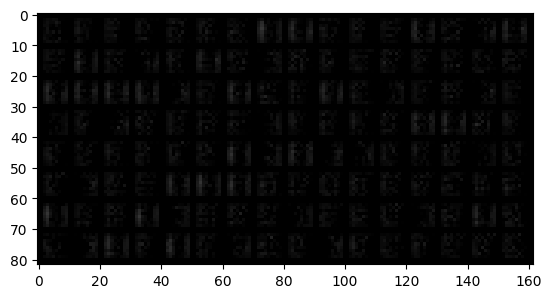

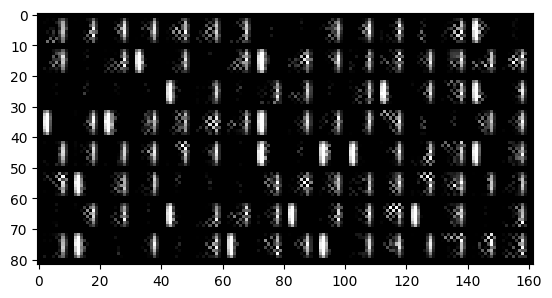

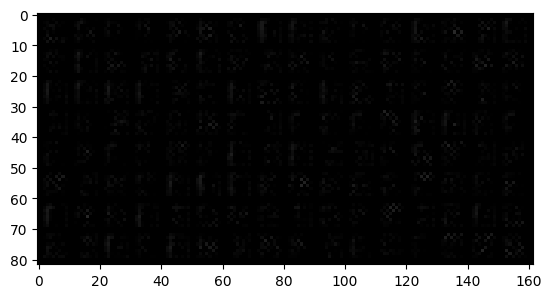

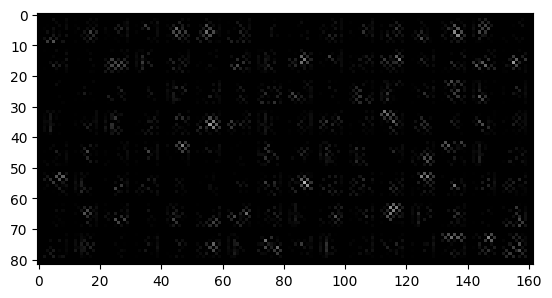

In [59]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

In [60]:
from tqdm import tqdm

In [61]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].cuda()
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().chunk(2, dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:01<00:00, 60.73it/s]


In [62]:
print(z_cs.shape)

torch.Size([10000, 4, 8, 8])


In [63]:
from sklearn.manifold import TSNE

In [64]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

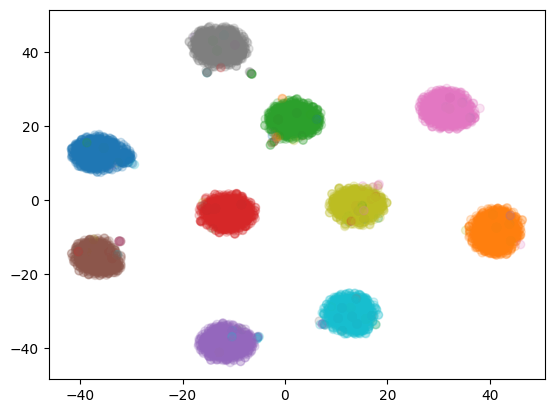

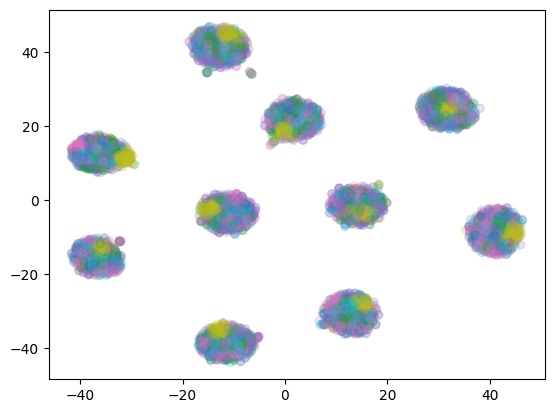

In [65]:
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
plt.show()
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=styles.numpy(), cmap='tab10', alpha=0.2)
plt.show()

In [68]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_ss.view(z_ss.shape[0], -1).numpy())

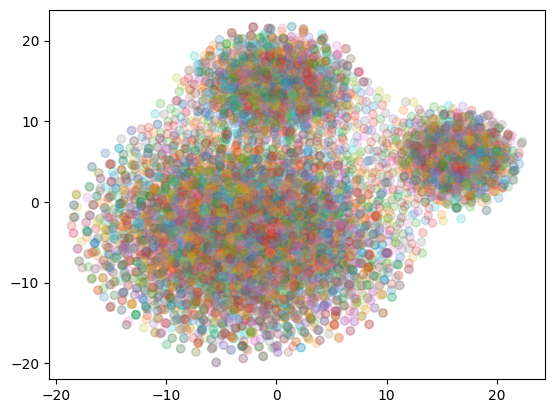

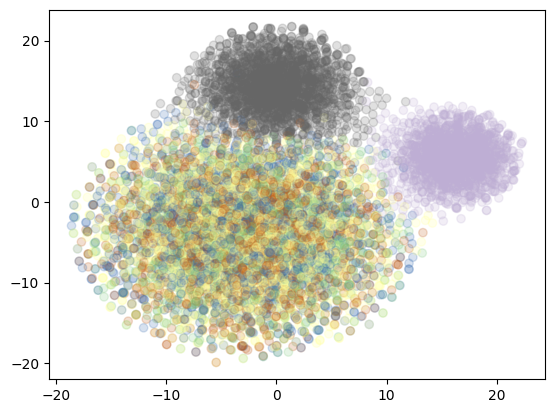

In [69]:
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
plt.show()
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=styles.numpy(), cmap='Accent', alpha=0.2)
plt.show()

In [66]:
z_c, z_s = mu.chunk(2, dim=1)
z_s = torch.cat([z_s[2:], z_s[:2]], dim=0)
z = torch.cat([z_c, z_s], dim=1).contiguous()
z.shape


torch.Size([128, 8, 8, 8])

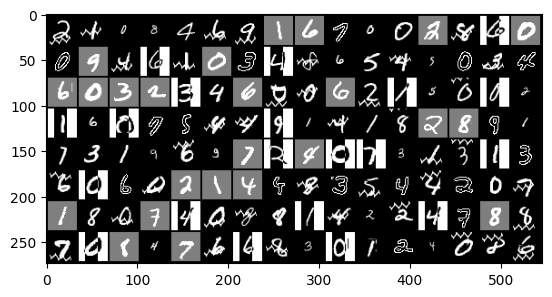

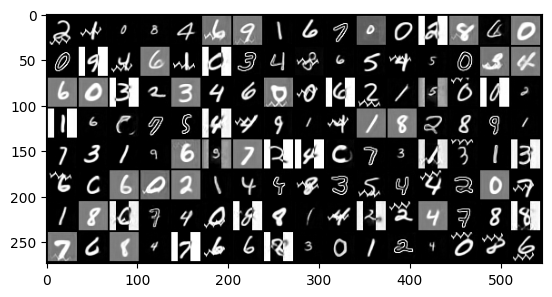

In [67]:
x = next(iter(test_loader))['image'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))
plt.show()
with torch.no_grad():
    best_model.eval()
    z = z * 0.18215
    xhat = best_model.decoder(z)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

interestingly, the current channel-wise disentanglement cannot differentiate all styles but only some of them.